# Data Mining Course Spark Exercise
## Sharif University of Technology

In this notebook, we are going to analyze tweets.
Outline of the exercise:
* Recommender systems
* user-user collaborating filter
* minHash

# Name: Mohammad Mehdi Zare
# Student Number: 


In [1]:
# installation
!pip install pyspark
!pip install findspark

In [2]:
import findspark
findspark.init()

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("HW3") \
    .master("local[*]") \
    .getOrCreate()

sc=spark.sparkContext

In [4]:
# libraries
import json
import numpy as np
import matplotlib.pyplot as plt
from itertools import groupby
from operator import itemgetter
from numpy import dot
from numpy.linalg import norm

In [5]:
# read data
tweets_rdd = sc.textFile("twitter_data.jsonl")


In [6]:
# load json data 
json_rdd = tweets_rdd.map(lambda x : json.loads(x))
json_formatted_str = json.dumps(json_rdd.take(1)[0], indent=4)
print(json_formatted_str)

{
    "publish_source": "<a href=\"https://mobile.twitter.com\" rel=\"nofollow\">Twitter Web App</a>",
    "in_reply_to_status_id_str": null,
    "in_reply_to_user_id_str": null,
    "in_reply_to_status_id": null,
    "in_reply_to_user_id": null,
    "in_reply_to_screen_name": null,
    "truncated": false,
    "is_quote_status": true,
    "retweet_count": 32,
    "reply_count": 129,
    "quote_count": 12,
    "favorite_count": 162,
    "favorited": false,
    "retweeted": false,
    "possibly_sensitive": false,
    "lang": "fa",
    "geo": null,
    "view_count": 27433,
    "tweet_type": "quoted",
    "emojis": null,
    "text": "\u067e\u0647\u0644\u0648\u0627\u0646\u200c\u067e\u0647\u0644\u0648\u06cc\u061b \u06cc\u0627\u0631 \u062f\u0648\u0627\u0632\u062f\u0647\u0645 \u062e\u0645\u06cc\u0646\u06cc\u060c \u062e\u0627\u0645\u0646\u0647\u200c\u0627\u06cc \u0648 \u062c.\u0627!\n\n\u0641\u06a9\u0631 \u0645\u06cc\u200c\u06a9\u0646\u06cc\u062f \u0627\u06af\u0631 \u0631\u0636\u0627 \u067e\u06

In [7]:
# a function to create (user_id, tweet_id) as cell of utility matrix, in this function I just consider tweets type (replied, generated, retweet, quoted)
# and for type generated and replied make a tuple and for retweet and quoted make two tuple.
def create_triple(x):
    id=x['id']
    user_id = x['user']['id']
    term=x['tweet_type']
    if term == "replied":
        id_r = x['in_reply_to_status_id_str']
        return[(user_id,[id_r])]
    elif term == "quoted":
        if x.get('quoted_status').get('id',0)!= 0:
            id_q = x['quoted_status']['id']
            return [(user_id, [id]), (user_id, [id_q])]
        else: 
            return [(user_id, [id])]
    elif term == "generated":
        return [(user_id,[id])]
    elif term == "retweeted":
        id_r = x['retweeted_status']['id']
        return[(user_id, [id]), (user_id, [id_r])]


In [8]:
# In data, some tweets have incomplete data
incomp=json_rdd.filter(lambda x: x['tweet_type']=="quoted" and x.get('quoted_status').get('id',0)==0).collect()
print("sample of incomplete data: ")
print(incomp[1])
print("number of incomplete data : "+str(len(incomp)))

sample of incomplete data: 
{'publish_source': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id_str': None, 'in_reply_to_status_id': None, 'in_reply_to_user_id': None, 'in_reply_to_screen_name': None, 'truncated': False, 'is_quote_status': True, 'retweet_count': 1, 'reply_count': 0, 'quote_count': 1, 'favorite_count': 3, 'favorited': False, 'retweeted': False, 'possibly_sensitive': None, 'lang': 'fa', 'geo': None, 'view_count': 235, 'tweet_type': 'quoted', 'emojis': None, 'text': 'ننویسد اقا اون مهریه کوفتی رو تعداد بالا ننویسید!\nاونی که به مهر بالا اصرار داره دیگه به چه زبونی بهتون بگه میخواد بعدا بدبختتون کنه؟\nیا ازدواج نکنید یا از مهر بالا فرار کنید', 'user': {'id': '1363594775539159045', 'id_str': '1363594775539159045', 'created_at': 1613941316, 'name': 'وکیل الرعایا', 'screen_name': 'md_s_law', 'location': 'tehran', 'description': 'حسبنا الله و نعم الوکیل', 'verified': False, 'followers_count': 1124, 'friends_count': 1431, 'listed_count': 1, 'favourites_count': 3955

In [9]:
# Use the above function to map each user to all related tweets
filter_rdd= json_rdd.map(lambda x: (create_triple(x)))
filter_rdd.take(10)

[[('1180273217795170304', ['1719504915700015121']),
  ('1180273217795170304', ['1718426467254566975'])],
 [('1689500371377401856', ['1719505170222964822'])],
 [('1283249761995362305', ['1719452613375062038'])],
 [('875259218370199552', ['1719505296920330649'])],
 [('1323619702925455361', ['1719505720721179046'])],
 [('854179818178347008', ['1719506014347632644'])],
 [('1185342890064650241', ['1719497061778051558'])],
 [('66147692', ['1719506830332699085'])],
 [('1316456805531299840', ['1719506844430053655'])],
 [('88447782', ['1719506990710263937'])]]

In [10]:
# For each user make a vector of tweets that are related to the user
users_vector=filter_rdd.flatMap(lambda x:x)\
.reduceByKey(lambda x,y:x+y)

users_vector.take(3)

[('975589943278911488', ['1718987782343790676', '1725232134426640487']),
 ('1004052664882118657',
  ['1719512438704324824',
   '1719909218394710293',
   '1720657680241402109',
   '1720768246268268891',
   '1721360917797958102',
   '1721732547078684754',
   '1722498194863538624',
   '1722517985787592755',
   '1722546299147329594',
   '1722803173709017206',
   '1722868095600013760',
   '1723045877395116438',
   '1723548243701768279',
   '1723548243701768279',
   '1724081713305759789',
   '1724656617013075969',
   '1724736197539320317',
   '1726129718817349707',
   '1728168319767716231',
   '1728393962853953691',
   '1728464155256975629',
   '1728696799777456128',
   '1728696826264519125',
   '1729564990850445408',
   '1729730469778919894',
   '1730334710633533914']),
 ('1497542707107008519', ['1719387457278341184'])]

In [11]:
# find the number of tweets to set an index for them
tweets_len=users_vector.map(lambda x: x[1])\
.flatMap(lambda x : x)\
.distinct()\
.collect()
len_unique = len(tweets_len)

In [12]:
len_unique

205713

In [13]:
# set index for each tweet
indexes = list(range(1,len_unique+1))
pairs=zip(tweets_len,indexes)
dic_tweets = dict(pairs)
dic_tweets

{'1720657680241402109': 1,
 '1729730469778919894': 2,
 '1724443805888262167': 3,
 '1724239083688308921': 4,
 '1721990291861778843': 5,
 '1724771254186418220': 6,
 '1723186706864816468': 7,
 '1726501778856755296': 8,
 '1729364051971510741': 9,
 '1719456189384180113': 10,
 '1719566442033807845': 11,
 '1720885704878616701': 12,
 '1720709663916740895': 13,
 '1721824914745766160': 14,
 '1721908848187916684': 15,
 '1726942268035330107': 16,
 '1730237320769544634': 17,
 '1719599788440604691': 18,
 '1721206919384207396': 19,
 '1721219572605272287': 20,
 '1723764028101562463': 21,
 '1724688576703607259': 22,
 '1727273728042541440': 23,
 '1730129234289414338': 24,
 '1728372845393391939': 25,
 '1720531026596733377': 26,
 '1724153228458066203': 27,
 '1725091727197753508': 28,
 '1723083165604979010': 29,
 '1726017117345009898': 30,
 '1726642476684046852': 31,
 '1727789620593606955': 32,
 '1728887920785039593': 33,
 '1729527907314188614': 34,
 '1724145449680994374': 35,
 '1725215023252062579': 36,
 

In [14]:
# for each user, x is list of related tweets.
# first make (tweets_index , 1), then sum tuples that have same key. for example (a,1), (a,1), (b,1)->(a,2),(b,1)
def minhash(x):
    list=[]
    for i in x:
        list.append((dic_tweets[i],1))
    first = itemgetter(0)
    sums = [(k, sum(item[1] for item in tups_to_sum))
            for k, tups_to_sum in groupby(sorted(list, key=first), key=first)]
    return sums

In [15]:
user_vector1=users_vector.map(lambda x: (x[0], minhash(x[1])))
user_vector1.take(5)

[('975589943278911488', [(60200, 1), (157248, 1)]),
 ('1004052664882118657',
  [(1, 1),
   (2, 1),
   (12028, 1),
   (36227, 1),
   (36228, 1),
   (48262, 1),
   (48263, 1),
   (48264, 1),
   (48265, 1),
   (60201, 1),
   (72307, 1),
   (72308, 1),
   (84260, 1),
   (84261, 2),
   (84262, 1),
   (96671, 1),
   (108877, 1),
   (133190, 1),
   (133191, 1),
   (145248, 1),
   (157249, 1),
   (157250, 1),
   (169513, 1),
   (181551, 1),
   (193694, 1)]),
 ('1497542707107008519', [(12029, 1)]),
 ('1244928207842938881', [(96672, 1)]),
 ('3345517396', [(72309, 1), (84263, 1), (133192, 1), (133193, 1)])]

In [51]:
# plot top users according to how many tweets.
u_c=user_vector1.map(lambda x: (len(x[1]),x[0])).top(30)
counts,users =zip(*u_c)

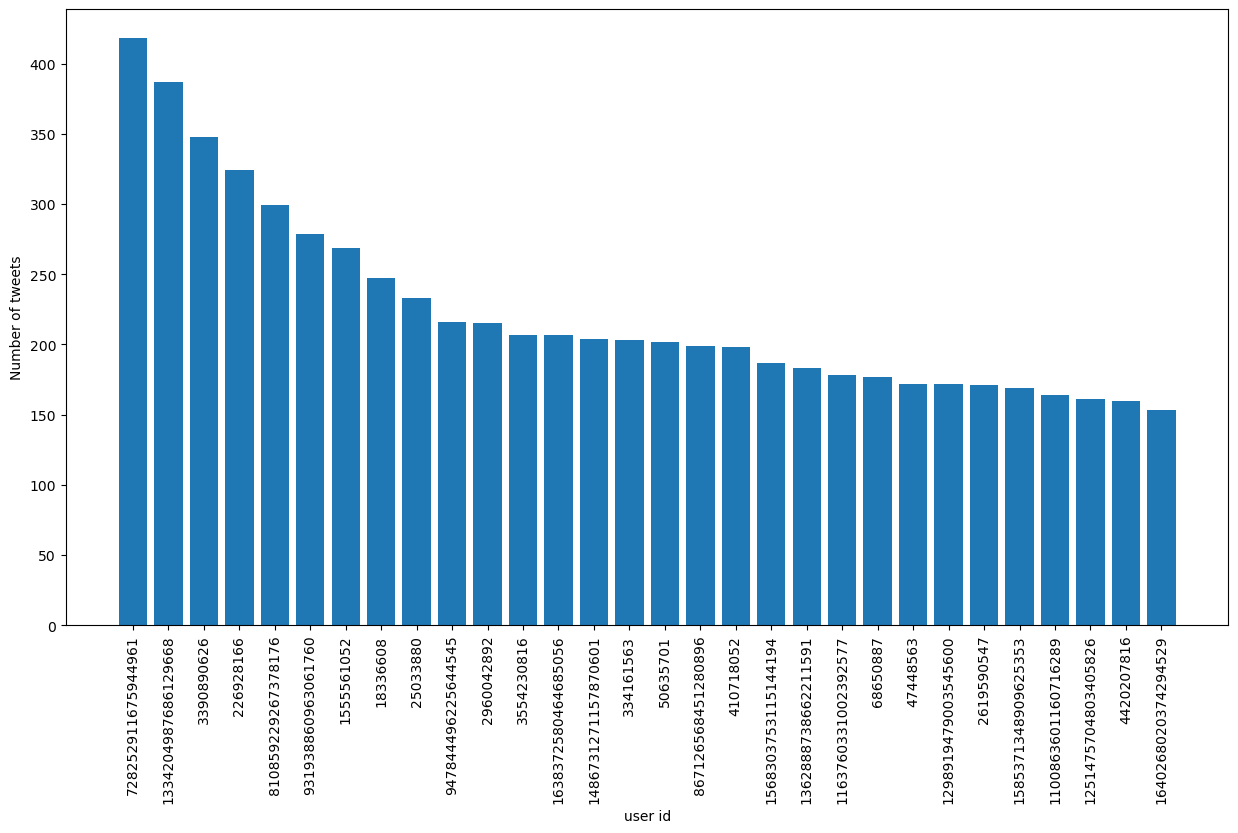

In [52]:

plt.figure(figsize=(15, 8))
indices = np.arange(len(u_c))
plt.bar(indices, counts)
plt.xticks(indices, users, rotation='vertical')
plt.xlabel("user id")
plt.ylabel("Number of tweets")
plt.show()

In [56]:
#  here plot frequency of each tweets 
t_c=user_vector1.flatMap(lambda x: x[1]). reduceByKey(lambda x,y : x+y).map(lambda x: (x[1],x[0])).top(30)
p = dict(zip(dic_tweets.values(),dic_tweets.keys()))
indices1 = np.arange(len(t_c))


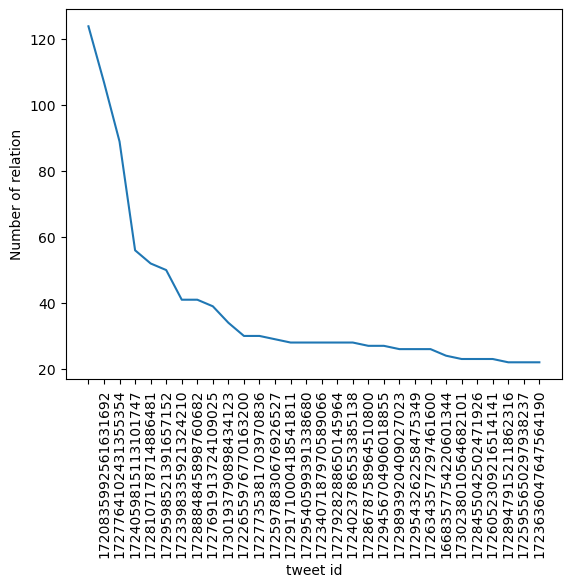

In [58]:
counts1 ,tweets1 = zip(*t_c)
tweets1=sc.parallelize(tweets1).map(lambda x: p[x]).collect()
plt.xlabel("tweet id")
plt.ylabel("Number of relation")
plt.plot(indices1,counts1)
plt.xticks(indices1, tweets1, rotation='vertical')
plt.show()


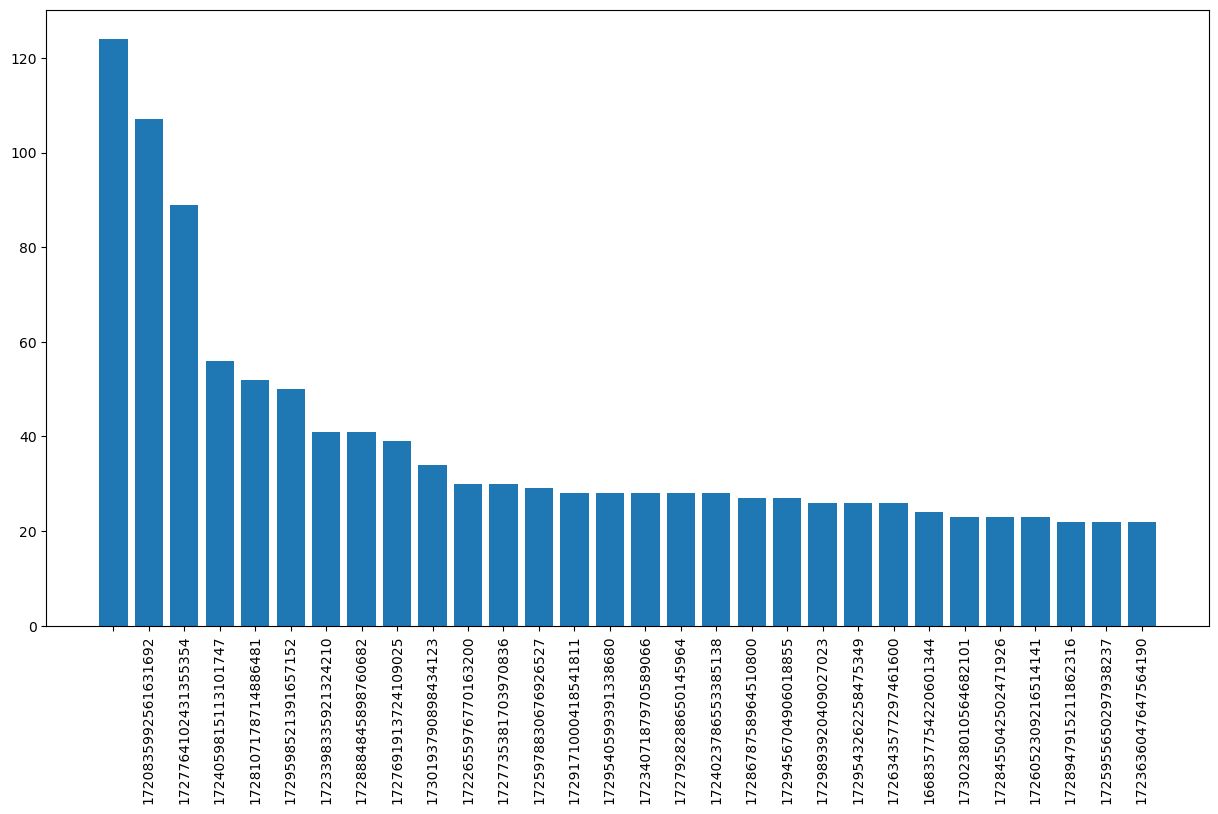

In [59]:
plt.figure(figsize=(15, 8))
indices1 = np.arange(len(t_c))
plt.bar(indices1, counts1)
plt.xticks(indices1, tweets1, rotation='vertical')
plt.show()


In [19]:
# create a dictionary for each user that The key is the user ID and values are a list of tuples (tweet_index, frequency)
dic_vector=dict(user_vector1.collect())

In [20]:
#  get all user ids to count them.
users_id=user_vector1.map(lambda x:x[0]).collect()
len(users_id)

68562

In [21]:
def intersection(a,b):
    c=[]
    for i in a:
        m,n=i
        for j,k in b:
            if m==j:
                c.append(m)
                break
    return c
# make a vector of values of b in order a 
def make_vector(a,b):
    ans=[]
    for i in a:
      for m,n in b:
          if m==i:
              ans.append(n)
    return ans

In [22]:
# For all users find similar users by for. this method is not optimum and is just used to find a few good samples.
# The better way is implementing LSH and similar users go to the same bucket.
# ans=[]
# for i in users_id:
#     ans=[]
#     for j in users_id:
#         a=dic_vector[i]
#         b=dic_vector[j]
#         aa=intersection(a,b)
#         a1=make_vector(aa,a)
#         b1=make_vector(aa,b)
#         X, a = map(list, zip(*a))
#         X, b = map(list, zip(*b))
#         cos_sim = dot(a1, b1)/(norm(a)*norm(b))
#         if cos_sim>.2:
#             ans.append((j,cos_sim))
#     print(ans)

In [23]:
# make dictionary of (user_id, tweet_id)
user_tweets_dict=dict(users_vector.collect())

In [24]:
# main function 
# input: user_id
# return similar users and recommend some tweet id for the user.
# I used cosine similarity as the measure.
def find_similar_tweets_for_user(user_id):
    ans=[]
    a=dic_vector[user_id]
    for j in users_id:
        b=dic_vector[j]
        aa=intersection(a,b)
        a1=make_vector(aa,a)
        b1=make_vector(aa,b)
        X, a2 = map(list, zip(*a))
        X, b2 = map(list, zip(*b))
        cos_sim = dot(a1, b1)/(norm(a2)*norm(b2))
        if cos_sim>0 and cos_sim<.9:
            ans.append((j,cos_sim))
    print("these users are similar : ")
    print(ans)
    print("user may like these tweets:  ")
    tweets_ans=[]
    for i,_ in ans:
        tweets_ans+=user_tweets_dict[i]

    print(np.setdiff1d(tweets_ans, user_tweets_dict[user_id]))

In [25]:
# call this with your sample user id
sample_user_id='1004052664882118657'
find_similar_tweets_for_user(sample_user_id)

these users are similar : 
[('1583401081631031299', 0.1091089451179962), ('1117524754678681600', 0.0944911182523068), ('1470253980664147968', 0.3779644730092272)]
user may like these tweets:  
['1720330395323941009' '1720835833161195738' '1720837641589907668'
 '1728131934784745705' '1729194735754265083']
